In [2]:
import requests

# Fetch public IP
response = requests.get("http://checkip.amazonaws.com")
if response.status_code == 200:
    public_ip = response.text.strip()
    print(f"Public IP: {public_ip}")
else:
    print(f"Failed to fetch public IP. Status code: {response.status_code}")

# The public IP should be in the whitelist of the AWS server, contact Sabah Hussain for access 

Public IP: 27.16.145.157


In [3]:
import os
import os.path
import pymysql
from sshtunnel import SSHTunnelForwarder
import pandas as pd
import time
import numpy as np
import seaborn as sns

import matplotlib
matplotlib.use('Agg')  # Use the Anti-Grain Geometry backend for non-GUI plotting
import matplotlib.pyplot as plt

def get_quote_data(date, symbol):
    """
    Fetch quote data for a specific date and symbol from Alp_Quotes.
    Checks if data already exists in a file; skips query if it does.
    """
    # -------------------------------
    # 0. Ensure the Data directory exists
    # -------------------------------
    data_dir = 'Data'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        print(f"Created directory: {data_dir}")

    # -------------------------------
    # 1. Transform symbol for filename
    # -------------------------------
    # Example: "XAU/USD" -> "XAUUSE"
    symbol_transformed = symbol.replace('/', '')

    # -------------------------------
    # 2. Build the partition name
    # -------------------------------
    date = pd.Timestamp(date)
    month_map = {
        1: "jan", 2: "feb", 3: "mar", 4: "apr", 5: "may", 6: "jun",
        7: "jul", 8: "aug", 9: "sep", 10: "oct", 11: "nov", 12: "dec"
    }
    partition_name = f"p_{month_map[date.month]}_{date.year}"
    
    # -------------------------------
    # 3. Build time filter boundaries
    # -------------------------------
    if not isinstance(date, pd.Timestamp):
        date = pd.Timestamp(date)
    start_str = date.strftime("%Y-%m-%d 00:00:00")
    end_str = (date + pd.Timedelta(days=1)).strftime("%Y-%m-%d 00:00:00")
    
    # -------------------------------
    # 4. Clean up symbol for file naming
    # -------------------------------
    date_str = date.strftime("%Y-%m-%d")
    file_name = f"{symbol_transformed}_{date_str}.pkl"
    file_path = os.path.join(data_dir, file_name)
    
    # -------------------------------
    # 5. Check if file exists locally
    # -------------------------------
    print(file_path)
    if os.path.exists(file_path):
        try:
            print(f"Loading data from local file: {file_path}")
            df = pd.read_pickle(file_path)
            return df
        except Exception as e:
            print(f"ERROR loading local file {file_path}: {str(e)}")
            # Proceed to fetch from server if loading fails

    # -------------------------------
    # 6. Build the SQL query
    # -------------------------------
    query = f"""
        SELECT 
            MakerId, 
            CoreSymbol, 
            TimeRecorded, 
            TimeSent, 
            TimeReceived, 
            Depth, 
            Side, 
            Price, 
            Size, 
            Provider, 
            IndicativeFlags, 
            QuoteFlags, 
            DisabledFlags, 
            ForwardPriceDelta, 
            id
        FROM Alp_Quotes PARTITION ({partition_name})
        FORCE INDEX (idx_time_recorded)
        WHERE 
            CoreSymbol = '{symbol}'
            AND TimeRecorded >= '{start_str}'
            AND TimeRecorded < '{end_str}';
    """
    
    ssh_host = '18.133.184.11'
    ssh_user = 'ubuntu'
    ssh_key_file = '/Users/jackhan/Desktop/Alpfin/OneZero_Data.pem'
    db_host = '127.0.0.1'
    db_port = 3306
    db_user = 'Ruize'
    db_password = 'Ma5hedPotato567='
    db_name = 'Alp_CPT_Data'
    
    columns = [
        "MakerId",
        "CoreSymbol",
        "TimeRecorded",
        "TimeSent",
        "TimeReceived",
        "Depth",
        "Side",
        "Price",
        "Size",
        "Provider",
        "IndicativeFlags",
        "QuoteFlags",
        "DisabledFlags",
        "ForwardPriceDelta",
        "id"
    ]
    
    try:
        with SSHTunnelForwarder(
            (ssh_host, 22),
            ssh_username=ssh_user,
            ssh_pkey=ssh_key_file,
            remote_bind_address=(db_host, db_port),
            allow_agent=False,
            host_pkey_directories=[]
        ) as tunnel:
            
            connection = pymysql.connect(
                host='127.0.0.1',
                port=tunnel.local_bind_port,
                user=db_user,
                password=db_password,
                database=db_name,
                connect_timeout=10
            )
            
            try:
                cursor = connection.cursor()
                
                # Start Query Timer
                query_start_time = time.time()
                print("Start Query: ", query)
                cursor.execute(query)
                query_duration = time.time() - query_start_time
                print(f"Query Execution Time: {query_duration:.2f} seconds.")
                
                # Start Data Transfer Timer
                transfer_start_time = time.time()
                rows = cursor.fetchall()
                transfer_duration = time.time() - transfer_start_time
                print(f"Data Transfer Time: {transfer_duration:.2f} seconds.")
                
                total_duration = query_duration + transfer_duration
                print(f"[{symbol} | {date_str}] Total Time: {total_duration:.2f} seconds.")
                
                print("Fetch Success")
                df = pd.DataFrame(rows, columns=columns)
                
                # Save the dataframe locally for future use
                try:
                    df.to_pickle(file_path)
                    print(f"Data saved locally to {file_path}")
                except Exception as e:
                    print(f"ERROR saving data to {file_path}: {str(e)}")
                
                return df
            
            finally:
                cursor.close()
                connection.close()
                
    except Exception as e:
        print(f"ERROR for {symbol} on {date_str}: {str(e)}")
        return None

# Example usage
# requested_date = pd.Timestamp("2025-01-08")
# df_result = get_quote_data(requested_date, "XAU/USD")


def PointSpreadDisplay(df_input, trade_vol, date, maker_id="Britannia"):
    df_loaded = df_input[df_input['MakerId'] == maker_id]
    depth_dfs = {}  # Dictionary to store dataframes for each depth

    for depth in range(7):  # Depth ranges from 0 to 6
        depth_dfs[f'sell_df_depth{depth}'] = df_loaded[(df_loaded["Side"] == 0) & (df_loaded["Depth"] == depth)].copy()
        depth_dfs[f'sell_df_depth{depth}'] = depth_dfs[f'sell_df_depth{depth}'].rename(
            columns={
                "Price": f"Sell_Price_Depth{depth}", 
                "Size": f"Sell_Size_Depth{depth}"
            }
        )
        depth_dfs[f'sell_df_depth{depth}'] = depth_dfs[f'sell_df_depth{depth}'][["CoreSymbol", "TimeRecorded", f"Sell_Price_Depth{depth}", f"Sell_Size_Depth{depth}"]]

        depth_dfs[f'buy_df_depth{depth}'] = df_loaded[(df_loaded["Side"] == 1) & (df_loaded["Depth"] == depth)].copy()
        depth_dfs[f'buy_df_depth{depth}'] = depth_dfs[f'buy_df_depth{depth}'].rename(
            columns={
                "Price": f"Depth{depth}_Buy_Price", 
                "Size": f"Depth{depth}_Buy_Size"
            }
        )
        depth_dfs[f'buy_df_depth{depth}'] = depth_dfs[f'buy_df_depth{depth}'][["CoreSymbol", "TimeRecorded", f"Depth{depth}_Buy_Price", f"Depth{depth}_Buy_Size"]]

    # Initialize the merged dataframe with the first depth's dataframes
    merged_df = depth_dfs['sell_df_depth0']
    # Iterate through the remaining depths and merge them
    for depth in range(1, 7):
        merged_df = merged_df.merge(depth_dfs[f'sell_df_depth{depth}'], on=["CoreSymbol", "TimeRecorded"], how="outer")

    for depth in range(0, 7):
        merged_df = merged_df.merge(depth_dfs[f'buy_df_depth{depth}'], on=["CoreSymbol", "TimeRecorded"], how="outer")

    def calculate_price_difference_per_row(row, trade_vol):
        # Initialize variables for buy and sell computations
        total_buy_vol = 0.0
        total_sell_vol = 0.0
        weighted_buy_price = 0.0
        weighted_sell_price = 0.0

        # Calculate total available volumes for buy and sell
        max_buy_vol = np.sum([row[f"Depth{depth}_Buy_Size"] for depth in range(7)])
        max_sell_vol = np.sum([row[f"Sell_Size_Depth{depth}"] for depth in range(7)])

        # Cap trade volume at the maximum available volume
        capped_trade_vol = min(trade_vol, max_buy_vol, max_sell_vol)

        # Simulate buy process
        remaining_vol = capped_trade_vol
        for depth in range(7):
            buy_price = row[f"Depth{depth}_Buy_Price"]
            buy_size = row[f"Depth{depth}_Buy_Size"]

            # Accumulate volume and weighted price
            if remaining_vol <= 0:
                break
            buyable_vol = min(buy_size, remaining_vol)
            weighted_buy_price += np.multiply(buyable_vol, buy_price)
            total_buy_vol += buyable_vol
            remaining_vol -= buyable_vol

        # Simulate sell process
        remaining_vol = capped_trade_vol
        for depth in range(7):
            sell_price = row[f"Sell_Price_Depth{depth}"]
            sell_size = row[f"Sell_Size_Depth{depth}"]

            # Accumulate volume and weighted price
            if remaining_vol <= 0:
                break
            sellable_vol = min(sell_size, remaining_vol)
            weighted_sell_price += np.multiply(sellable_vol, sell_price)
            total_sell_vol += sellable_vol
            remaining_vol -= sellable_vol

        # Calculate average prices with protection against division by zero
        avg_buy_price = np.divide(weighted_buy_price, total_buy_vol) if total_buy_vol > 0 else np.nan
        avg_sell_price = np.divide(weighted_sell_price, total_sell_vol) if total_sell_vol > 0 else np.nan

        # Calculate price difference
        price_difference = avg_buy_price - avg_sell_price if not np.isnan(avg_buy_price) and not np.isnan(avg_sell_price) else np.nan

        return price_difference

    merged_df["Point_Diff"] = merged_df.apply(
        lambda row: calculate_price_difference_per_row(row, trade_vol), axis=1
    )
        
    plt.figure(figsize=(12, 6))
    plt.plot(
        merged_df["TimeRecorded"], 
        merged_df["Point_Diff"], 
        marker="o",         # shape of the point (circle)
        linestyle="none",   # no connecting line
        markersize=2,       # size of the dots
        alpha=0.5
    )
    plt.title(f"Point Difference Over Time on {date} at trading volume {trade_vol}", fontsize=16)
    plt.xlabel("TimeRecorded", fontsize=14)
    plt.ylabel("Point Difference", fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(linestyle="--", alpha=0.7)
    plt.tight_layout()
    # plt.show()

    # 1. Quick overview (count, mean, std, min, quartiles, max, etc.)
    print("=== Describe (default percentiles) ===")
    print(merged_df['Point_Diff'].describe())

    # 2. Custom percentiles (e.g., 5th, 25th, 50th, 75th, 95th)
    print("\n=== Describe (custom percentiles) ===")
    print(merged_df['Point_Diff'].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

    # 3. Specific summary statistics
    mean_val = merged_df['Point_Diff'].mean()
    median_val = merged_df['Point_Diff'].median()
    std_val = merged_df['Point_Diff'].std()
    var_val = merged_df['Point_Diff'].var()
    min_val = merged_df['Point_Diff'].min()
    max_val = merged_df['Point_Diff'].max()
    skew_val = merged_df['Point_Diff'].skew()
    kurt_val = merged_df['Point_Diff'].kurt()

    print("\n=== Specific Statistics ===")
    print(f"Mean: {mean_val}")
    print(f"Median: {median_val}")
    print(f"Standard Deviation: {std_val}")
    print(f"Variance: {var_val}")
    print(f"Min: {min_val}")
    print(f"Max: {max_val}")
    print(f"Skewness: {skew_val}")
    print(f"Kurtosis: {kurt_val}")

    # 1. Calculate Q1, Q3, and IQR
    Q1 = merged_df["Point_Diff"].quantile(0.25)
    Q3 = merged_df["Point_Diff"].quantile(0.75)
    IQR = Q3 - Q1

    # 2. Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")

    # 3. Identify outliers
    outliers = merged_df[(merged_df["Point_Diff"] < lower_bound) | (merged_df["Point_Diff"] > upper_bound)]
    print(f"Number of Outliers: {len(outliers)}")

    # 4. Plotting
    plt.figure(figsize=(12, 7))

    # Plot histogram for all data
    sns.histplot(
        merged_df["Point_Diff"], 
        bins=50, 
        color='skyblue', 
        edgecolor='black', 
        label='Data', 
        alpha=0.7
    )

    # Overlay histogram for outliers
    if not outliers.empty:
        sns.histplot(
            outliers["Point_Diff"], 
            bins=50, 
            color='red', 
            edgecolor='black', 
            label='Outliers', 
            alpha=0.7
        )

    # Plot vertical lines for bounds
    plt.axvline(lower_bound, color='green', linestyle='--', linewidth=2, label=f'Lower Bound ({lower_bound:.2f})')
    plt.axvline(upper_bound, color='purple', linestyle='--', linewidth=2, label=f'Upper Bound ({upper_bound:.2f})')

    # Title and labels
    plt.title("Histogram of Point_Diff with Outliers Highlighted", fontsize=18)
    plt.xlabel("Point_Diff", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)

    # Legend
    plt.legend(fontsize=12)

    # Grid 
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Tight layout for better spacing
    plt.tight_layout()

    # Display the plot
    # plt.show()

    plt.close('all')

Data/XAUUSD_2025-01-08.pkl
Loading data from local file: Data/XAUUSD_2025-01-08.pkl


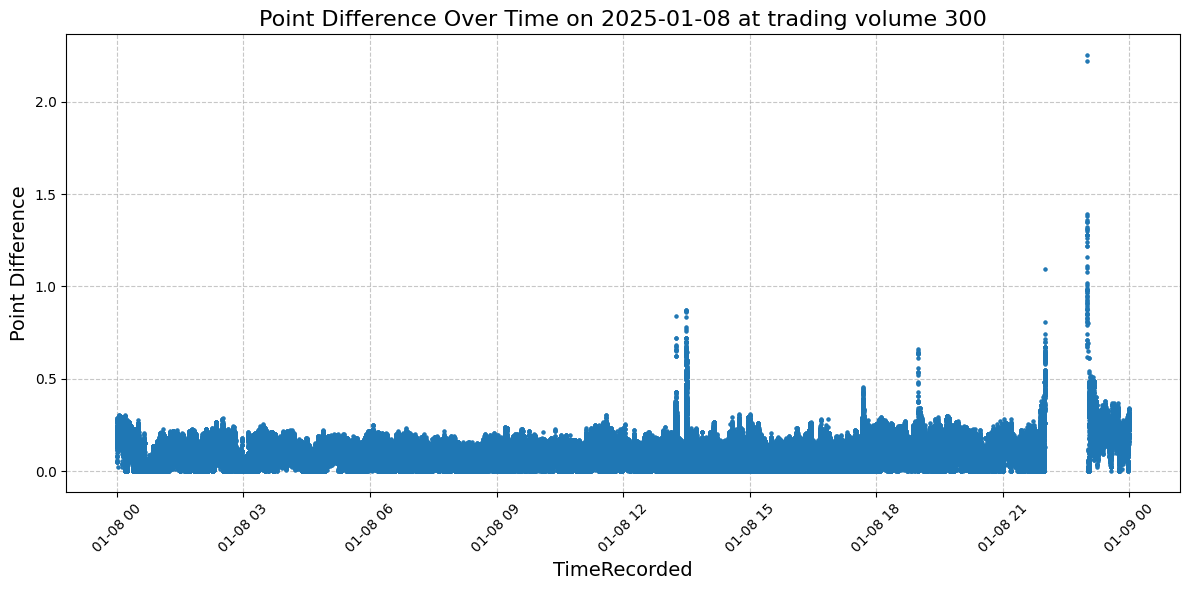

=== Describe (default percentiles) ===
count    3.886656e+06
mean     9.274045e-02
std      6.071708e-02
min     -4.547474e-13
25%      4.666667e-02
50%      9.333333e-02
75%      1.333333e-01
max      2.253333e+00
Name: Point_Diff, dtype: float64

=== Describe (custom percentiles) ===
count    3.886656e+06
mean     9.274045e-02
std      6.071708e-02
min     -4.547474e-13
5%       0.000000e+00
25%      4.666667e-02
50%      9.333333e-02
75%      1.333333e-01
95%      1.900000e-01
max      2.253333e+00
Name: Point_Diff, dtype: float64

=== Specific Statistics ===
Mean: 0.09274045053982957
Median: 0.09333333333324845
Standard Deviation: 0.06071707535849626
Variance: 0.003686563240089314
Min: -4.547473508864641e-13
Max: 2.2533333333335577
Skewness: 0.9161634590025156
Kurtosis: 9.377645160795296
Lower Bound: -0.08333333333325754
Upper Bound: 0.26333333333309383
Number of Outliers: 26436


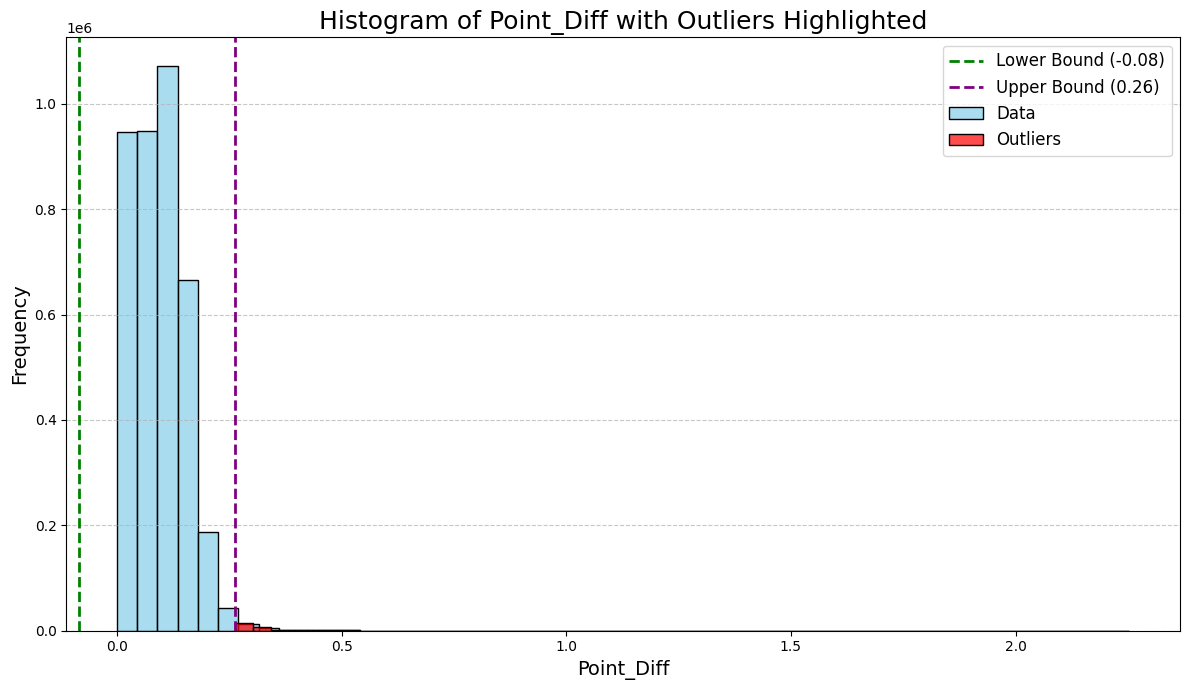

In [4]:
dataInput = get_quote_data("2025-01-08", "XAU/USD")
PointSpreadDisplay(dataInput, 300, "2025-01-08","Britannia")

Data/XAUUSD_2025-01-08.pkl
Loading data from local file: Data/XAUUSD_2025-01-08.pkl


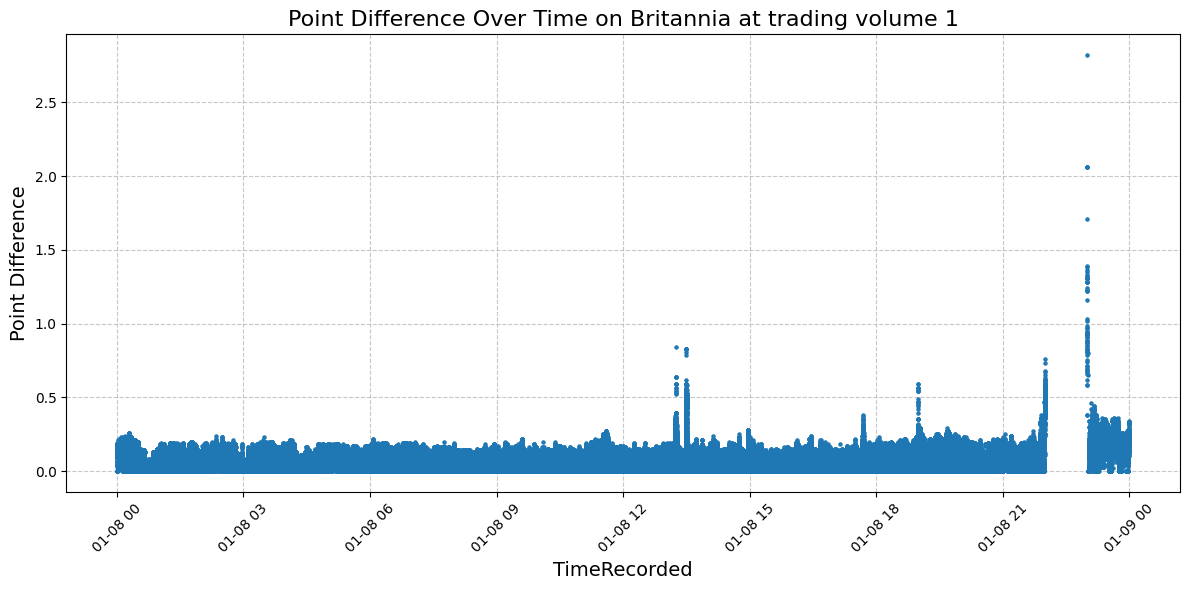

=== Describe (default percentiles) ===
count    3.886668e+06
mean     6.458359e-02
std      5.517583e-02
min      0.000000e+00
25%      1.000000e-02
50%      6.000000e-02
75%      1.000000e-01
max      2.820000e+00
Name: Point_Diff, dtype: float64

=== Describe (custom percentiles) ===
count    3.886668e+06
mean     6.458359e-02
std      5.517583e-02
min      0.000000e+00
5%       0.000000e+00
25%      1.000000e-02
50%      6.000000e-02
75%      1.000000e-01
95%      1.600000e-01
max      2.820000e+00
Name: Point_Diff, dtype: float64

=== Specific Statistics ===
Mean: 0.06458358676378108
Median: 0.05999999999994543
Standard Deviation: 0.055175825624722764
Variance: 0.0030443717333698134
Min: 0.0
Max: 2.819999999999709
Skewness: 1.4309147648137261
Kurtosis: 20.737404651769822
Lower Bound: -0.12499999999931788
Upper Bound: 0.2349999999994452
Number of Outliers: 21192


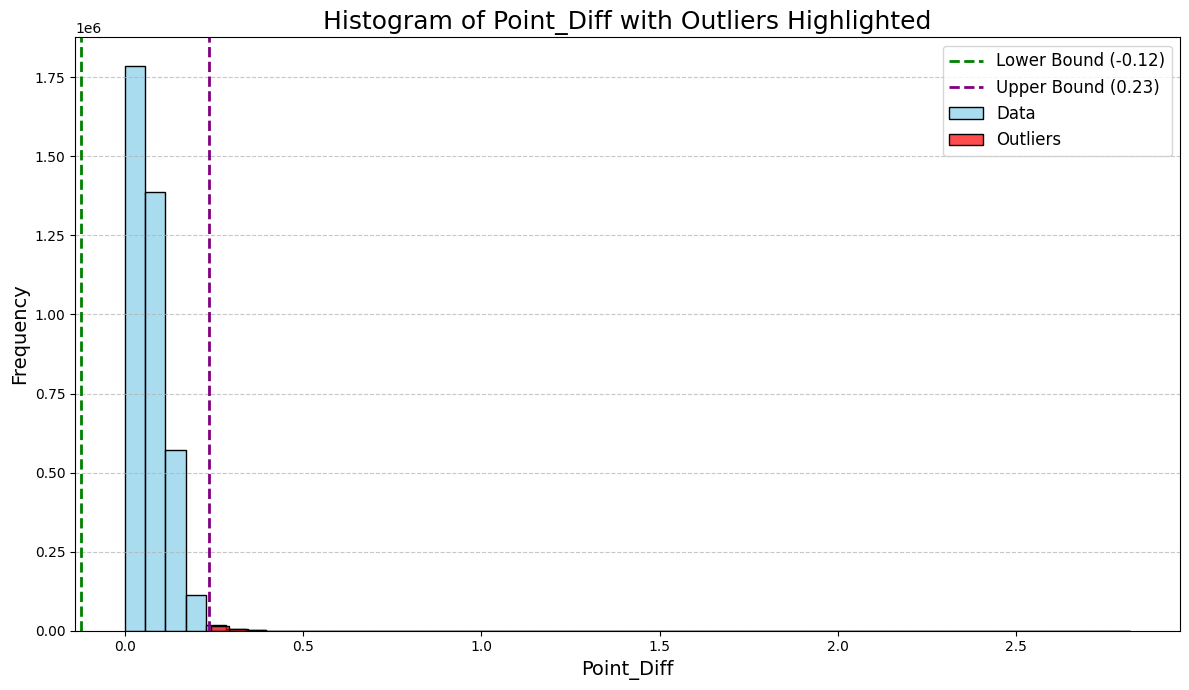

In [6]:
dataInput = get_quote_data("2025-01-08", "XAU/USD")
PointSpreadDisplay(dataInput, 1, "Britannia")